In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data84434


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [3]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
  Using cached https://mirrors.bfsu.edu.cn/pypi/web/packages/d1/41/e6495bd7d3781cee623ce23ea6ac73282a373088fcd0ddc809a047b18eae/beautifulsoup4-4.9.3-py3-none-any.whl
  Using cached https://mirrors.bfsu.edu.cn/pypi/web/packages/36/69/d82d04022f02733bf9a72bc3b96332d360c0c5307096d76f6bb7489f7e57/soupsieve-2.2.1-py3-none-any.whl


In [4]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [5]:
from __future__ import print_function
import numpy as np
import sys 
import matplotlib.pyplot as plt
import pandas as pd
import paddle
import paddle.fluid as fluid
import math

In [1]:
datapath="data/data84434/mycar.csv" #训练集
testdatapath="data/data84434/test.csv"#验证集

params_dirname = "mycar.model" #params_dirname用于定义模型保存路径。
BATCH_SIZE = 100 #定义每次读取数据量大小
num_epochs = 20  #训练轮次
learning_rate = 0.005  #学习率
use_cuda = True #True=GPU ，False=cpu
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()


NameError: name 'fluid' is not defined

* 上牌时间(0-140) time
* 里程数(0-250000) meter
* 汽车厂商(1-10) broad    
* 汽车类型(1-4) Model
* 汽车排量(0-6.2)displacement
* 最大马力(20-585)horsepower
* 变速箱(1-3)Gearbox
* 重大事故(0-1) accident
* 泡水火烧(0-1) soak
* 轻微碰撞(0-1) slight_collision
* 漆面修复次数(0-3) Paint_repair
* 钣金修复次数(0-3) Sheet_metal_repair
* 外观件更换次数(0-3)  Appearance_replacement
* 





读取处理数据 定义模型

In [7]:
data = pd.read_csv(datapath)#读取数据
row = data.shape[0]
column = data.shape[1]
data_2=data
global x_raw,train_data,test_data
x_raw = data_2.T.copy()
maximums, minimums, avgs= data_2.max(axis=0), data_2.min(axis=0), data_2.mean(axis=0)
feature_num = data_2.shape[1]
for i in range(feature_num-1):#售价不用改
    data_2.iloc[:, [i]] = (data_2.iloc[:, [i]]- minimums[i])/(maximums[i]-minimums[i])#归一化


print(data_2.head())

#划分训练集 测试集
data_3=np.array(data_2)
print(data_3[0])
ratio = 0.8
offset = int(data_3.shape[0]*ratio)
train_data = data_3[:offset].copy()
test_data = data_3[offset:].copy()
print(train_data)
print(len(train_data))

#读取器
def read_data(data_set):

    def reader():
        """
 
        Return：
            data[:-1],data[-1:] --使用yield返回生成器
                data[:-1]表示前n-1个元素，也就是训练数据，
                data[-1:]表示最后一个元素，也就是对应的标签(价格)
        """
        for data in data_set:
            yield data[:-1],data[-1:]
    return reader
test_array = ([10,100],[20,200])
print("test_array for read_data:")
for value in read_data(test_array)():
    print(value)   

# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        read_data(train_data), 
        buf_size=1000)#表示每次缓存BUF_SIZE个数据项，并进行打乱
        ,batch_size=BATCH_SIZE)

#设置测试 reader
test_reader = paddle.batch(
    paddle.reader.shuffle(
        read_data(test_data), 
        buf_size=1000),
    batch_size=BATCH_SIZE)

#定义训练模型

x = fluid.layers.data(name='x', shape=[13], dtype='float32')
# 标签数据，fluid.layers.data表示数据层,name=’y’：名称为y,输出类型为tensor
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
# 输出层，fluid.layers.fc表示全连接层，input=x: 该层输入数据为x
y_first = fluid.layers.fc(input=x, size=4, act=None, bias_attr=True)
y_predict = fluid.layers.fc(input=y_first, size=1, act=None, bias_attr=True)

# 定义损失函数为均方差损失函数,并且求平均损失，返回值名称为avg_loss
loss = fluid.layers.square_error_cost(input=y_predict, label=y)
avg_loss = fluid.layers.mean(loss)
# 定义执行器(参数随机初始化):
exe = fluid.Executor(place)
# 配置训练程序:
main_program = fluid.default_main_program() # 获取默认/全局主函数
startup_program = fluid.default_startup_program() # 获取默认/全局启动程序
#克隆main_program得到test_program
#有些operator在训练和测试之间的操作是不同的，例如batch_norm，使用参数for_test来区分该程序是用来训练还是用来测试
#该api不会删除任何操作符,请在backward和optimization之前使用
test_program = main_program.clone(for_test=True)

sgd_optimizer = fluid.optimizer.SGDOptimizer(learning_rate)
# sgd_optimizer = fluid.optimizer.SGD(learning_rate)  # 随机梯度下降
# sgd_optimizer = fluid.optimizer.Adam(learning_rate)
sgd_optimizer.minimize(avg_loss)


def train_test(executor, program, reader, feeder, fetch_list):
    accumulated = 1 * [0]
    count = 0
    for data_test in reader():
        outs = executor.run(
            program=program, feed=feeder.feed(data_test), fetch_list=fetch_list)
        accumulated = [x_c[0] + x_c[1][0] for x_c in zip(accumulated, outs)]  # 累加测试过程中的损失值
        count += 1 # 累加测试集中的样本数量
    return [x_d / count for x_d in accumulated] # 计算平均损失





       time     meter     broad     Model  displacement  horsepower  Gearbox  \
0  0.409091  0.385457  0.888889  0.333333      1.000000    0.219469      0.0   
1  0.214286  0.153954  1.000000  1.000000      0.000000    0.722124      1.0   
2  0.584416  0.538231  0.444444  0.333333      0.666667    0.734513      0.5   
3  0.168831  0.153128  0.333333  0.000000      0.000000    0.207080      0.0   
4  0.396104  0.385190  0.111111  0.333333      0.833333    0.341593      0.5   

   accident  soak  slight_collision  Paint_repair  Sheet_metal_repair  \
0       0.0   0.0          1.000000      1.000000            1.000000   
1       0.0   0.0          0.666667      1.000000            0.000000   
2       0.0   0.0          1.000000      0.000000            0.666667   
3       0.0   0.0          0.666667      1.000000            0.333333   
4       0.0   0.0          0.000000      0.333333            0.333333   

   Appearance_replacement     price  
0                0.333333  0.207784  
1   

训练

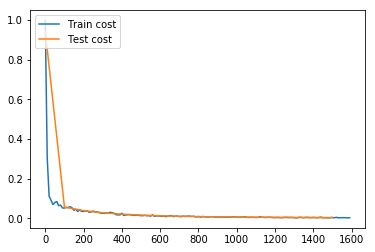

0
Test cost, Step 0, Cost 0.941696
1
Test cost, Step 100, Cost 0.057308
2
Test cost, Step 200, Cost 0.039609
3
Test cost, Step 300, Cost 0.028757
5
Test cost, Step 400, Cost 0.021703
6
Test cost, Step 500, Cost 0.016962
7
Test cost, Step 600, Cost 0.013612
8
Test cost, Step 700, Cost 0.011192
10
Test cost, Step 800, Cost 0.009403
11
Test cost, Step 900, Cost 0.008067
12
Test cost, Step 1000, Cost 0.007031
13
Test cost, Step 1100, Cost 0.006222
15
Test cost, Step 1200, Cost 0.005582
16
Test cost, Step 1300, Cost 0.005060
17
Test cost, Step 1400, Cost 0.004633
18
Test cost, Step 1500, Cost 0.004276


<Figure size 432x288 with 0 Axes>

In [8]:
#用于画图展示训练cost
from paddle.utils.plot import Ploter
train_prompt = "Train cost"
test_prompt = "Test cost"
plot_prompt = Ploter(train_prompt, test_prompt)
step = 0

# 训练主循环
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])
exe.run(startup_program)
exe_test = fluid.Executor(place)



for pass_id in range(num_epochs):

    for data_train in train_reader():
        avg_loss_value, = exe.run(main_program,
                                  fetch_list=[avg_loss],
                                  feed=feeder.feed(data_train))
        if step % 10 == 0:  # 每10个批次记录并输出一下训练损失.
            plot_prompt.append(train_prompt, step, avg_loss_value[0])
            plot_prompt.plot()

        if step % 100 == 0:  # 每100批次记录并输出一下测试损失
            test_metics = train_test(executor=exe_test,
                                     program=test_program,
                                     reader=test_reader,
                                     fetch_list=[avg_loss.name],
                                     feeder=feeder)
            plot_prompt.append(test_prompt, step, test_metics[0])
            plot_prompt.plot()
            print(pass_id)
            print("%s, Step %d, Cost %f" %(test_prompt, step, test_metics[0]))
        step += 1

        if math.isnan(float(avg_loss_value[0])):
            sys.exit("got NaN loss, training failed.")

        #保存训练参数到之前给定的路径中
        if params_dirname is not None:
            fluid.io.save_inference_model(params_dirname, ['x'], [y_predict], exe)


验证

In [12]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时的所有变量都将分配给新的scope。
    #从指定目录中加载 预测用的model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(   #fetch_targets: 推断结果
                                    params_dirname,    #model_save_dir:模型训练路径 
                                    infer_exe)         #infer_exe: 预测用executor
   
    datatest = pd.read_csv(testdatapath)
    row2 = datatest.shape[0]
    print(row2)
    data_2= datatest.loc[:,['time', 'meter', 'broad', 'Model', 'displacement',
           'horsepower','Gearbox','accident','soak','slight_collision',
           'Paint_repair','Sheet_metal_repair','Appearance_replacement']]
    data_y=np.array(datatest.loc[:,['price']])

    maximums, minimums, avgs= data.max(axis=0), data.min(axis=0), data.mean(axis=0)
    feature_num = data_2.shape[1]
    for i in range(feature_num):#售价不用改
        data_2.iloc[:, [i]] = (data_2.iloc[:, [i]]- minimums[i])/(maximums[i]-minimums[i])
    
    data_3=np.array(data_2)
    step=0
    array_lost=[]
    for number in range(row2):
        tensor_x = []
        tensor_x = [np.array(data_3[number]).astype("float32")]
        #print(tensor_x)
        results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(tensor_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
        step+=1               
        
        for idx, val in enumerate(results[0]):
            if val[0]<0.05 :
               
                val2=0.05
            else:
                val2=val[0]
                lost=abs(val2-data_y[number][0])#相差的绝对值
                array_lost.append(lost)#只统计大于0.05的数据
                
            print("%d: 预测%.2f 实际%.2f △=%.2f" % (number,val2,data_y[number],lost))
          
    mean_lost=np.mean(array_lost)
    print("平均偏差：")
    print("±△=",mean_lost)


预测

In [18]:
raw_x= [41,45058,9,2,4,498,2,0,0,0,1,3,0] #填入要预测的二手车的数据
'''['time', 'meter', 'broad', 'Model', 'displacement',
           'horsepower','Gearbox','accident','soak','slight_collision',
           'Paint_repair','Sheet_metal_repair','Appearance_replacement']
'''
print("平均偏差：±△=",mean_lost)
tensor_x = []
data = pd.read_csv(datapath)

maximums, minimums, avgs= data.max(axis=0), data.min(axis=0), data.mean(axis=0)
print(len(raw_x))
for i in range(len(raw_x)):
    tensor_x.append((raw_x[i] - minimums[i])/(maximums[i]-minimums[i]))


tensor_x = [np.array(tensor_x).astype("float32")]

print(tensor_x)
results = infer_exe.run(inference_program,                              #预测模型
                    feed={feed_target_names[0]: np.array(tensor_x)},  #喂入要预测的x值
                    fetch_list=fetch_targets)                       #得到推测结果             
for idx, val in enumerate(results[0]):
    if val[0]<0.05 :
        val2=0.05
    else:
        val2=val[0]


    print(" 预测：现价=（%.4f ±%.4f）*原价" % (val2,mean_lost))

平均偏差：±△= 0.04711204052811513
13
[array([0.25324675, 0.23113346, 0.8888889 , 0.33333334, 0.6666667 ,
       0.8460177 , 0.5       , 0.        , 0.        , 0.        ,
       0.33333334, 1.        , 0.        ], dtype=float32)]
 预测：现价=（0.5367 ±0.0471）*原价


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 